Let's see how the curvature affects the pairwise distances in the case of a balanced binary tree.  In order to make the distance matrices comparable across curvatures, we'll need to ensure that the particular "ordering" of the points in the space is the same in each case (recall that there are many choices, and which occurs is a function of the initial conditions).

Throughout, the tree is a balanced binary tree

```
(((12)(34))((56)(78)))
```

with all edge lengths equal to $0.25$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def balanced_binary_tree_distances(tree_height):
    """
    Return the matrix of pairwise distances of the leaves of a balanced binary tree,
    where the leaves are enumerated in a depth-first fashion.
    """
    num_leaves = 2 ** tree_height
    diss = np.empty((num_leaves, num_leaves), dtype=np.float64)
    for i in range(num_leaves):
        for j in range(num_leaves):
            diss[i,j] = 2 * _lowest_common_ancestor_height(i, j, tree_height)
    return diss

def _lowest_common_ancestor_height(i, j, tree_height):
    """
    In a balanced binary tree of height `tree_height`, return the height of the lowest
    common ancestor of leaves `i` and `j` (which are in range(2 ** tree_height))
    """
    for h in reversed(range(0, tree_height)):
        div = 2 ** h
        if (i // div) != (j // div):
            return h + 1
    return h

In [2]:
base_dist = 1/4
true_pairwise_dists = balanced_binary_tree_distances(3)
true_pairwise_dists *= base_dist  ## as though the edge lengths were base_dist

Our implementation works with the rates of site difference, so we need to invert the distance correction formula

```
dist = (-3 / 4) * np.log(1 - (4 / 3) * diffs_per_site)
```

to get the expected rate of difference, given the distance.

In [3]:
def distance_to_rate(dists):
    return 0.75 * (1 - np.exp(-4 * dists / 3))

### Normalisations

In finite data scenarios, we'd use the variance of the distance estimate to normalise the summands in the objective function.  For simplicity in this example, let's assume that the sequences are of infinite length.

In [4]:
rates_of_difference = distance_to_rate(true_pairwise_dists)
normalisations = np.ones_like(rates_of_difference, dtype=np.float64)

In [5]:
from hyperboloid import Hyperboloid
from cythonised.cy_sequence_mds_sg import SequenceMDS

num_leaves = true_pairwise_dists.shape[0]
init_stddev = 0.1
stopping_distance = 1e-8
max_rounds = -1
lr = 0.001
max_step_size = 0.1

def fit_smds(rho, dimension, initial_pts=None):
    rho_hyperboloid = Hyperboloid(local_dimension=dimension, rho=rho)
    if initial_pts is None:
        # generate initial points
        np.random.seed(0)
        initial_pts = rho_hyperboloid.initialisation_points(init_stddev, num_leaves)
            
    smds = SequenceMDS(rho=rho, lr=lr, max_step_size=max_step_size)
    smds.set_points(initial_pts.copy())
    converged, failed, checkpoints = smds.fit(rates_of_difference,
                                              normalisations,
                                              stopping_distance=stopping_distance,
                                              max_rounds=max_rounds,
                                              checkpoint_interval=1000)    
    pw_dists = rho_hyperboloid.pairwise_distances(smds.get_points())
    return converged, failed, checkpoints, pw_dists

In [9]:
rhos = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.25, 1.5, 1.75]

# Dimension 2

In [10]:
fitted_distances_dim2 = {}

converged, failed, checkpoints, fitted_distances_dim2[1.] = fit_smds(1., 2)
assert converged

# keep these points for later plotting
converged_points_dim2_rho1 = checkpoints[-1][0]

In [11]:
for rho in rhos[::-1]:
    converged, failed, checkpoints, fitted_distances_dim2[rho] = fit_smds(rho, 2)
    assert converged

# Dimension 3

In [12]:
fitted_distances_dim3 = {}

for rho in rhos[::-1]:
    converged, failed, checkpoints, fitted_distances_dim3[rho] = fit_smds(rho, 3)
    assert converged

In [49]:
def plot_points(ax, points):
    """
    Plot the given points, belonging to the 1-hyperboloid of local dimension 2,
    on the Poincaré disc.
    """
    rho_hyperboloid = Hyperboloid(local_dimension=2, rho=1.)

    circle = plt.Circle((0, 0), 1, fc='none', ec='black', linewidth=3, alpha=0.5)
    ax.add_artist(circle)
    lim = 1.1
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    
    def get_size(ppt):
        euc_dist = np.sqrt(ppt.dot(ppt))
        hyp_dist = 2 * np.arctanh(euc_dist)
        markersize = 0.7 * max(10 - 3 * hyp_dist, 0.5)
        return markersize

    for i, pt in enumerate(points):
        ppt = rho_hyperboloid.to_poincare_ball_point(pt)
        ax.plot(*ppt, marker='o', markersize=get_size(ppt), label='%i' % (i + 1))[0]
        ax.annotate(str(i+1), tuple(ppt + 0.02), fontsize=8)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


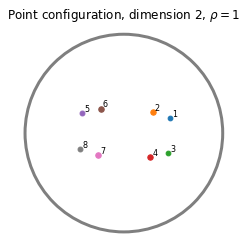

In [90]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_points(ax, converged_points_dim2)
ax.set_aspect('equal')
ax.set_title('Point configuration, dimension 2, $\\rho=1$')
plt.savefig('article/point-configuration-article.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


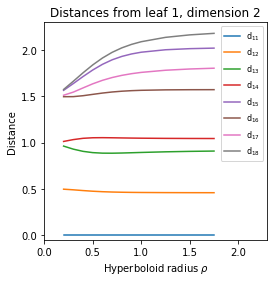

In [94]:
# plot distances for dim 2
fig, ax2 = plt.subplots(figsize=(4, 4))
for j in range(0, num_leaves):
    distances = [fitted_distances_dim2[rho][0, j] for rho in rhos]
    ax2.plot(rhos, distances, label='$\mathrm{d}_{1%i}$' % (j + 1))
ax2.set_ylim(-0.05, 2.3)
ax2.set_xlim(0., 2.3)
ax2.set_title('Distances from leaf 1, dimension 2')
ax2.set_ylabel('Distance')
ax2.set_xlabel('Hyperboloid radius $\\rho$')
ax2.legend(fontsize=8, handlelength=2)
plt.savefig('article/distance-rho-dependence-dimension-2-article.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


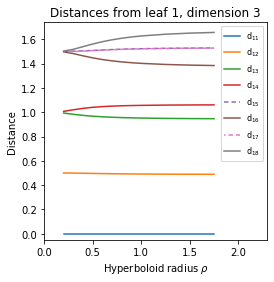

In [93]:
# plot distances for dim 3
fig, ax3 = plt.subplots(figsize=(4, 4))
reordering = [0, 1, 3, 2, 4, 5, 7, 6]
for j in range(8):
    distances = [fitted_distances_dim3[rho][0, reordering[j]] for rho in rhos]
    if j == 4:
        linestyle = (0, (3, 2))
    elif j == 6:
        linestyle = (2, (3, 2))
    else:
        linestyle = '-'
    ax3.plot(rhos, distances, label='$\mathrm{d}_{1%i}$' % (j + 1), linestyle=linestyle)
ax3.set_ylim(-0.05)
ax3.set_xlim(0., 2.3)
ax3.set_title('Distances from leaf 1, dimension 3')
ax3.set_ylabel('Distance')
ax3.set_xlabel('Hyperboloid radius $\\rho$')
ax3.legend(fontsize=8, handlelength=2)
plt.savefig('article/distance-rho-dependence-dimension-3-article.eps')
plt.show()

# Euclidean, dimension 2

In [155]:
from cythonised.cy_sequence_mds_sg import SequenceMDS
from scipy.spatial.distance import pdist, squareform

num_leaves = true_pairwise_dists.shape[0]
init_stddev = 0.1
stopping_distance = 0.
max_rounds = 100000
lr = 0.1
max_step_size = 0.1

def fit_euclidean_smds(dimension, initial_pts=None):
    rho_hyperboloid = Hyperboloid(local_dimension=dimension, rho=rho)
    if initial_pts is None:
        # generate initial points
        np.random.seed(1)
        initial_pts = np.zeros((num_leaves, dimension + 1), dtype=np.float64)
        initial_pts[:,:-1] = np.random.normal(size=(num_leaves, dimension)) * init_stddev
            
    smds = SequenceMDS(rho=np.inf, lr=lr, max_step_size=max_step_size)
    smds.set_points(initial_pts.copy())
    converged, failed, checkpoints = smds.fit(rates_of_difference,
                                              normalisations,
                                              stopping_distance=stopping_distance,
                                              max_rounds=max_rounds,
                                              checkpoint_interval=1000)    
    points = smds.get_points()
    pw_dists = squareform(pdist(points))
    return converged, failed, checkpoints, pw_dists

In [156]:
converged, failed, checkpoints, pw_dists = fit_euclidean_smds(2)

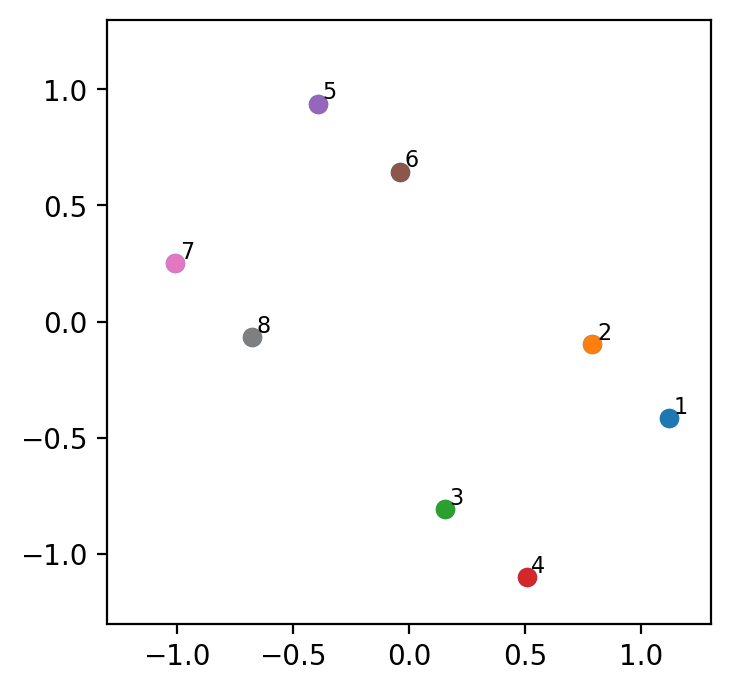

In [164]:
def plot_points(points):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.set_aspect('equal')
    ax.scatter(points[:,0], points[:,1])
    lim = 1.3
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    for i, pt in enumerate(points[:,:-1]):
        ax.plot(*pt, marker='o', label='%i' % (i + 1))[0]
        ax.annotate(str(i+1), tuple(pt + 0.02), fontsize=8)
    return ax
    
points = checkpoints[-1][0].copy()
ax = plot_points(points)
plt.savefig('article/euclidean-fit-1-article.eps')

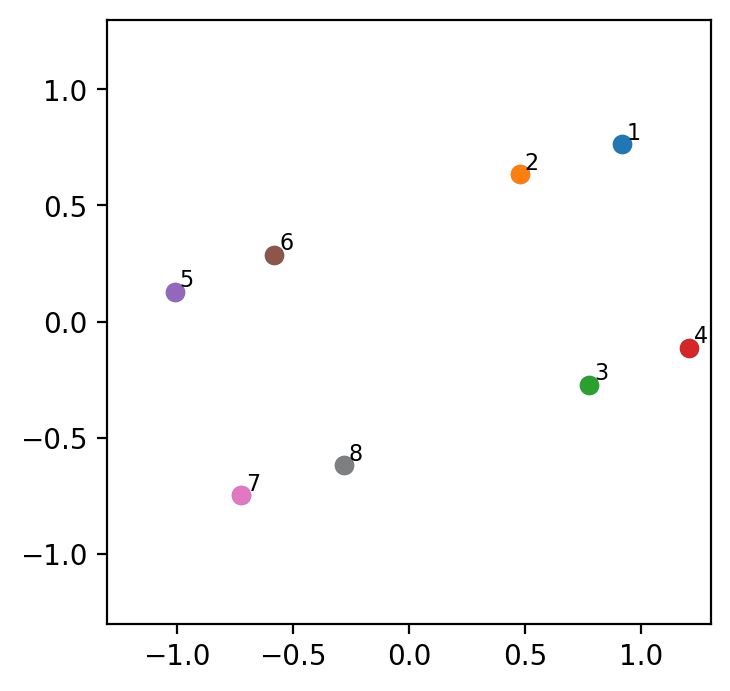

In [165]:
theta = np.pi / 3
points = checkpoints[-1][0].copy()
points[:,:-1] = points[:,:-1].dot(np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]))
ax = plot_points(points)
plt.savefig('article/euclidean-fit-2-article.eps')

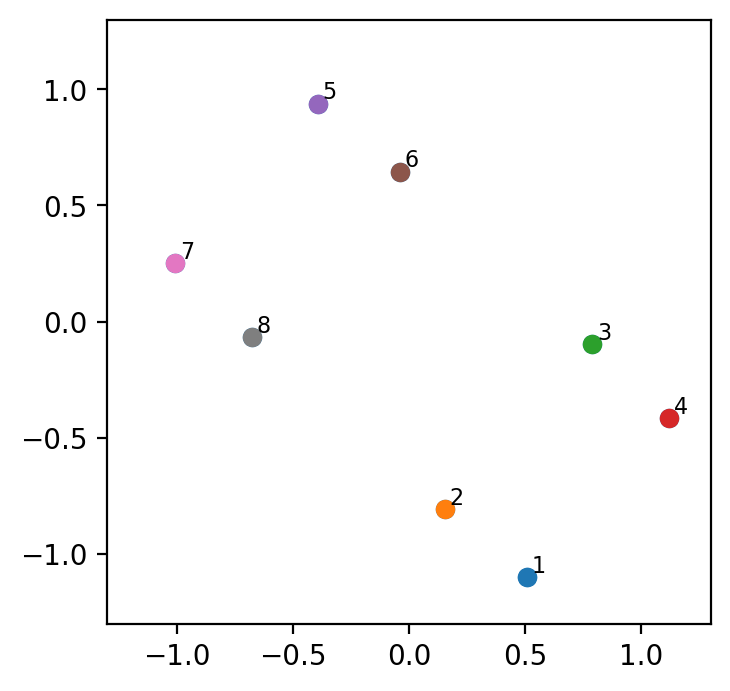

In [166]:
points = checkpoints[-1][0].copy()

def swap_rows(i, j):
    inter = points[i,:].copy()
    points[i,:] = points[j,:]
    points[j,:] = inter

swap_rows(0,3)
swap_rows(1,2)
ax = plot_points(points)
plt.savefig('article/euclidean-fit-3-article.eps')